## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Apr 23 20:05:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **03.01.2024** with version **YOLOv8.0.196**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.0/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Z2IczquHaYRw3cGIiTwz")
project = rf.workspace("smartmatabc").project("handwrittenalphabet")
version = project.version(3)
dataset = version.download("yolov8")

/content/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to HandwrittenAlphabet-3 in yolov8:: 100%|██████████| 3634/3634 [00:00<00:00, 11434.28it/s]


In [ ]:
# Resize all images in train, validation, and test splits to 640x640 and correct EXIF orientation
splits = ["train", "valid", "test"]
extensions = ["*.jpg", "*.png"]

for split in splits:
    image_dir = os.path.join(dataset.location, split, "images")
    for ext in extensions:
        for img_path in glob.glob(os.path.join(image_dir, ext)):
            try:
                with Image.open(img_path) as img:
                    img = ImageOps.exif_transpose(img)
                    img = img.resize((640, 640))
                    img.save(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")


In [ ]:
!pip install albumentations
import albumentations as A
import cv2
import os
import numpy as np

# Updated augmentation pipeline with corrected parameters
transform = A.Compose([
    # Rotate between -15° and +15°, always applied
    A.Rotate(limit=(-15, 15), p=1.0),
    # Blur with 3x3 kernel, always applied
    A.Blur(blur_limit=3, p=1.0),
     # Noise with intensity 0.1-0.3, always applied
    A.ISONoise(intensity=(0.1, 0.3), p=1.0),
    A.Resize(640, 640, always_apply=True)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], clip=True))

def augment_image(image_path, label_path, output_image_dir, output_label_dir, num_augmentations=3):
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bboxes = []
    class_labels = []
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            values = line.strip().split()
            if len(values) < 5:
                print(f"Skipping invalid line in {label_path}: {line}")
                continue
            # Take only the first 5 values (class_id, x, y, w, h)
            class_id, x, y, w, h = map(float, values[:5])
            bboxes.append([x, y, w, h])
            class_labels.append(int(class_id))
    except Exception as e:
        print(f"Error reading {label_path}: {e}")
        return

    # Skip if no valid bboxes
    if not bboxes:
        print(f"No valid bboxes in {label_path}, copying original image and label")
        aug_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
        aug_label_path = os.path.join(output_label_dir, os.path.basename(label_path))
        cv2.imwrite(aug_image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        with open(aug_label_path, 'w') as f:
            f.write("")
        return

    # Apply augmentations
    for i in range(num_augmentations):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        base_name = os.path.splitext(os.path.basename(image_path))[0]
        aug_image_path = os.path.join(output_image_dir, f"{base_name}_aug_{i}.jpg")
        cv2.imwrite(aug_image_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

        aug_label_path = os.path.join(output_label_dir, f"{base_name}_aug_{i}.txt")
        with open(aug_label_path, 'w') as f:
            for bbox, cls in zip(aug_bboxes, aug_labels):
                if len(bbox) == 4:  # Ensure valid bbox
                    f.write(f"{cls} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

# Augment all images in train folder
dataset_location = "/content/datasets/HandwrittenAlphabet-3"
input_image_dir = f"{dataset_location}/train/images"
input_label_dir = f"{dataset_location}/train/labels"
output_image_dir = input_image_dir
output_label_dir = input_label_dir

# Count original images
original_images = len([f for f in os.listdir(input_image_dir) if not f.startswith('.') and f.endswith(('.jpg', '.jpeg', '.png'))])
print(f"Original training images: {original_images}")

for img_name in os.listdir(input_image_dir):
    if not img_name.endswith(('.jpg', '.jpeg', '.png')):
        continue
    img_path = os.path.join(input_image_dir, img_name)
    label_path = os.path.join(input_label_dir, os.path.splitext(img_name)[0] + '.txt')
    if os.path.exists(label_path):
        augment_image(img_path, label_path, output_image_dir, output_label_dir, num_augmentations=5)
    else:
        print(f"No label file found for {img_path}, copying original image")
        aug_image_path = os.path.join(output_image_dir, img_name)
        aug_label_path = os.path.join(output_label_dir, os.path.splitext(img_name)[0] + '.txt')
        image = cv2.imread(img_path)
        if image is not None:
            cv2.imwrite(aug_image_path, image)
            with open(aug_label_path, 'w') as f:
                f.write("")

# Count total images after augmentation
total_images = len([f for f in os.listdir(input_image_dir) if not f.startswith('.') and f.endswith(('.jpg', '.jpeg', '.png'))])
print(f"Total training images after augmentation: {total_images}")

Argument(s) 'always_apply' are not valid for transform Resize


Original training images: 1266
Total training images after augmentation: 7596


In [ ]:
import os
import random
import glob
import shutil
from pathlib import Path
import pandas as pd


dataset_location = "/content/datasets/HandwrittenAlphabet-3"
base_path = Path(dataset_location)
train_img_dir = base_path / "train" / "images"
train_label_dir = base_path / "train" / "labels"
valid_img_dir = base_path / "valid" / "images"
valid_label_dir = base_path / "valid" / "labels"
test_img_dir = base_path / "test" / "images"
test_label_dir = base_path / "test" / "labels"
for dir_path in [valid_img_dir, valid_label_dir, test_img_dir, test_label_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)
train_images = glob.glob(str(train_img_dir / "*.*"))
total_images = len(train_images) + len(glob.glob(str(valid_img_dir / "*.*")))
+ len(glob.glob(str(test_img_dir / "*.*")))
print(f"Total images: {total_images}")
train_ratio = 0.7  # 70% train
valid_ratio = 0.2  # 20% valid
test_ratio = 0.1  # 10% test
num_train = int(total_images * train_ratio)
num_valid = int(total_images * valid_ratio)
num_test = total_images - num_train - num_valid
print(f"Target split: Train={num_train}, Valid={num_valid}, Test={num_test}")
all_images = []
for split_dir in [train_img_dir, valid_img_dir, test_img_dir]:
    all_images.extend(glob.glob(str(split_dir / "*.*")))
random.shuffle(all_images)
temp_img_dir = base_path / "temp" / "images"
temp_label_dir = base_path / "temp" / "labels"
temp_img_dir.mkdir(parents=True, exist_ok=True)
temp_label_dir.mkdir(parents=True, exist_ok=True)
for img_path in all_images:
    label_path = str(Path(img_path).with_suffix(".txt")).replace("images", "labels")
    shutil.move(img_path, temp_img_dir / Path(img_path).name)
    if os.path.exists(label_path):
        shutil.move(label_path, temp_label_dir / Path(label_path).name)
# Redistribute images and labels to splits
all_images = glob.glob(str(temp_img_dir / "*.*"))
random.shuffle(all_images)
def move_image_and_label(img_path, img_dest_dir, label_dest_dir):
    label_path = str(Path(img_path).with_suffix(".txt")).replace("images", "labels")
    shutil.move(img_path, img_dest_dir / Path(img_path).name)
    if os.path.exists(label_path):
        shutil.move(label_path, label_dest_dir / Path(label_path).name)
    else:
        with open(label_dest_dir / Path(label_path).name, 'w') as f:
            f.write("")
for img_path in all_images[:num_train]:
    move_image_and_label(img_path, train_img_dir, train_label_dir)
for img_path in all_images[num_train:num_train + num_valid]:
    move_image_and_label(img_path, valid_img_dir, valid_label_dir)
for img_path in all_images[num_train + num_valid:]:
    move_image_and_label(img_path, test_img_dir, test_label_dir)
shutil.rmtree(temp_img_dir.parent)
split_stats = []
for split, img_dir, label_dir in [
    ("train", train_img_dir, train_label_dir),
    ("valid", valid_img_dir, valid_label_dir),
    ("test", test_img_dir, test_label_dir)
]:
    img_files = glob.glob(str(img_dir / "*.*"))
    label_files = glob.glob(str(label_dir / "*.txt"))
    split_stats.append({"split": split, "images": len(img_files), "labels": len(label_files)})
stats_df = pd.DataFrame(split_stats)
print("Images/labels per split after rebalancing:")
print(stats_df)
data_yaml_path = base_path / "data.yaml"
if data_yaml_path.exists():
    import yaml
    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
    data_yaml['train'] = str(train_img_dir)
    data_yaml['val'] = str(valid_img_dir)
    data_yaml['test'] = str(test_img_dir)
    with open(data_yaml_path, 'w') as f:
        yaml.safe_dump(data_yaml, f)
    print("Updated data.yaml with new split paths")

Total images: 7959
Target split: Train=5571, Valid=1591, Test=797
Images/labels per split after rebalancing:
   split  images  labels
0  train    5571    5571
1  valid    1591    1591
2   test     979     979
Updated data.yaml with new split paths


Data exploration & understanding

In [ ]:
import os, random, glob, yaml
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
base_path = Path(dataset.location)

splits = ["train", "valid", "test"]
split_stats = []
for split in splits:
    img_files   = glob.glob(str(base_path / split / "images" / "*.*"))
    label_files = glob.glob(str(base_path / split / "labels" / "*.txt"))
    split_stats.append({"split": split,
                        "images": len(img_files),
                        "labels": len(label_files)})

stats_df = pd.DataFrame(split_stats)
print("Images/labels per split:")
print(stats_df, "\n")

Images/labels per split:
   split  images  labels
0  train    5571    5571
1  valid    1591    1591
2   test     979     979 



In [ ]:
# class names from data.yaml
with open(base_path / "data.yaml") as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml["names"]

Train-split class distribution:
    class_id class_name  count percentage
17         3          D    228      4.09%
22         4          E    227      4.07%
2         17          R    225      4.04%
14        22          W    224      4.02%
10        16          Q    224      4.02%
20        10          K    220      3.95%
5         25          Z    219      3.93%
7         24          Y    218      3.91%
19        23          X    218      3.91%
13         6          G    217      3.89%
21        19          T    216      3.87%
3         18          S    215      3.86%
18        20          U    214      3.84%
15         2          C    214      3.84%
1         21          V    214      3.84%
4         11          L    214      3.84%
8          8          I    214      3.84%
12        15          P    213      3.82%
9          9          J    211      3.78%
16         5          F    209      3.75%
25         1          B    207      3.71%
0          7          H    207      3.71%
6 

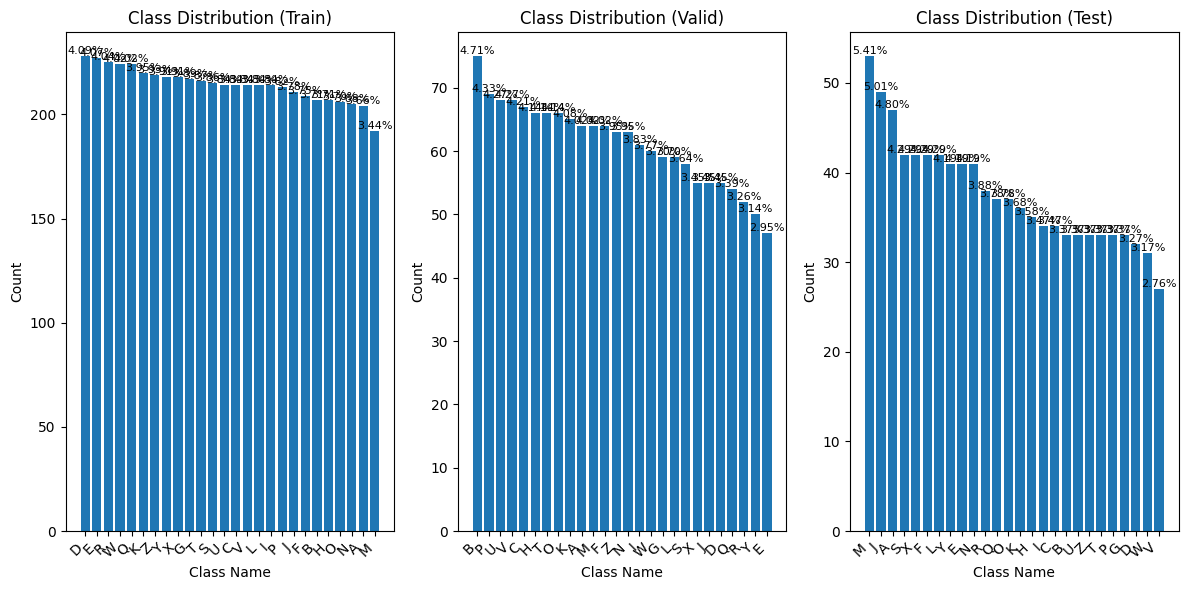

In [ ]:
#  Class Distribution Across All Splits
def get_class_distribution(split, class_names):
    class_counter = Counter()
    label_files = (base_path / split / "labels").glob("*.txt")
    for txt in label_files:
        try:
            with open(txt, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) < 5:
                        print(f"Skipping invalid line in {txt}: {line}")
                        continue
                    try:
                        class_id = int(float(parts[0]))
                        class_counter[class_id] += 1
                        while len(class_names) <= class_id:
                            class_names.append(f"class_{len(class_names)}")
                    except ValueError as e:
                        print(f"Error parsing class ID in {txt}: {line}. Error: {e}")
        except Exception as e:
            print(f"Error reading {txt}: {e}")

    total_annotations = sum(class_counter.values())
    cls_df = pd.DataFrame({
        "class_id": list(class_counter.keys()),
        "class_name": [class_names[i] if i < len(class_names) else f"class_{i}" for i in class_counter.keys()],
        "count": list(class_counter.values()),
        "percentage": [(count / total_annotations * 100) if total_annotations > 0 else 0 for count in class_counter.values()]
    }).sort_values("count", ascending=False)
    cls_df["percentage"] = cls_df["percentage"].map("{:.2f}%".format)
    return cls_df

# Plot class distributions for all splits
plt.figure(figsize=(12, 6))
for i, split in enumerate(splits, 1):
    cls_df = get_class_distribution(split, class_names)
    print(f"{split.capitalize()}-split class distribution:")
    print(cls_df, "\n")

    plt.subplot(1, 3, i)
    bars = plt.bar(cls_df["class_name"], cls_df["count"])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Class Distribution ({split.capitalize()})")
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    for bar, percentage in zip(bars, cls_df["percentage"]):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                 ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
unique_sizes = set()
for split in splits:
    img_dir = base_path / split / "images"
    img_files = glob.glob(str(img_dir / "*.*"))
    for img_path in img_files:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue
        h, w = img.shape[:2]
        unique_sizes.add((w, h))
print("Unique image sizes (width x height):")
for size in unique_sizes:
    print(size)


Unique image sizes (width x height):
(640, 640)


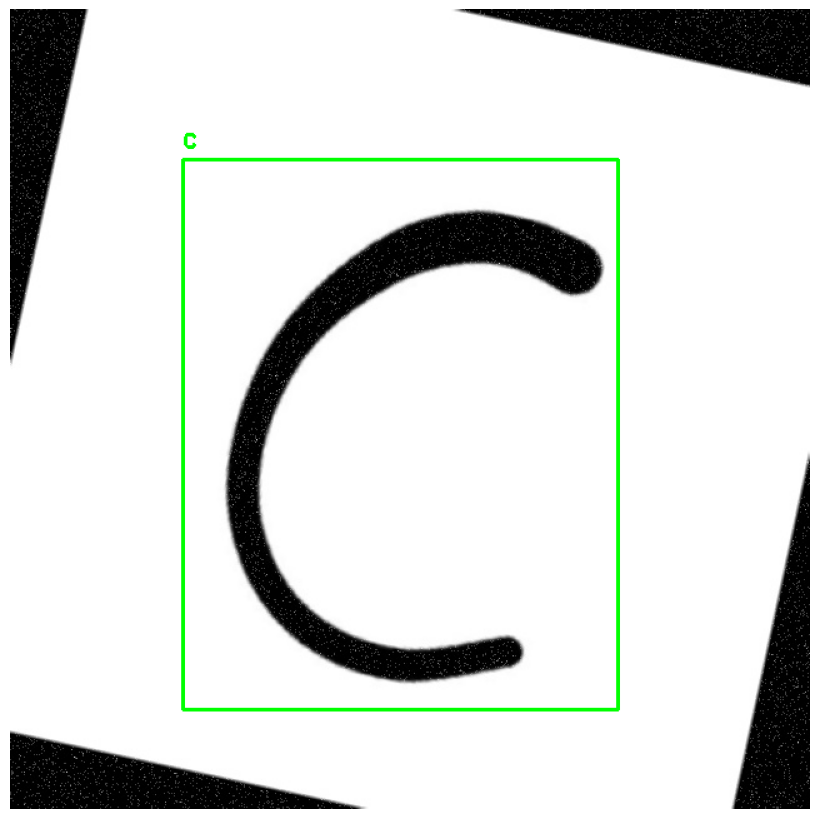

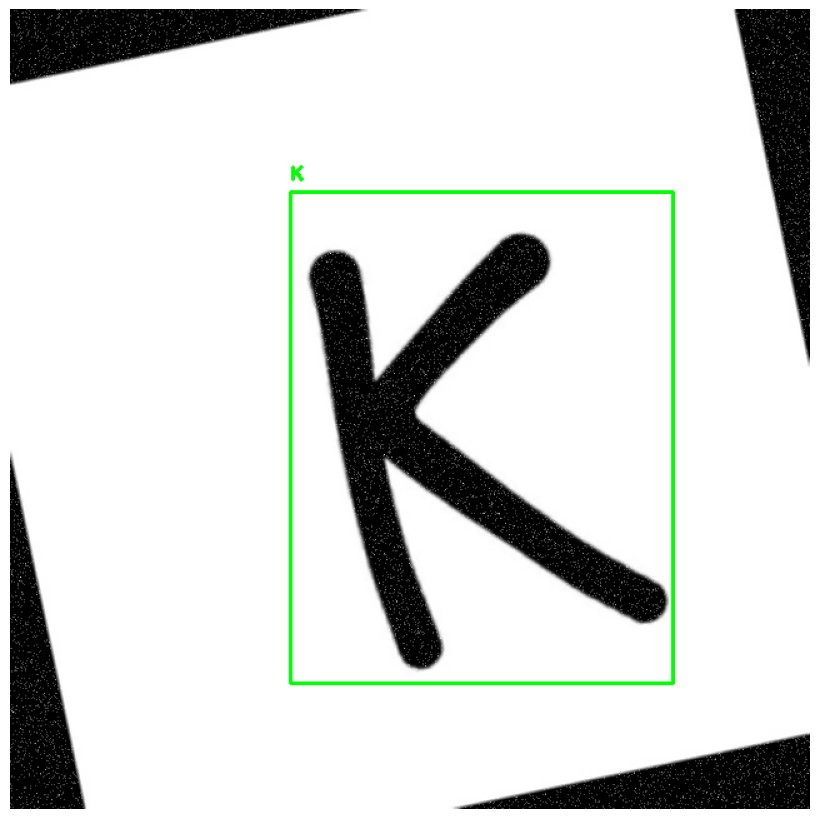

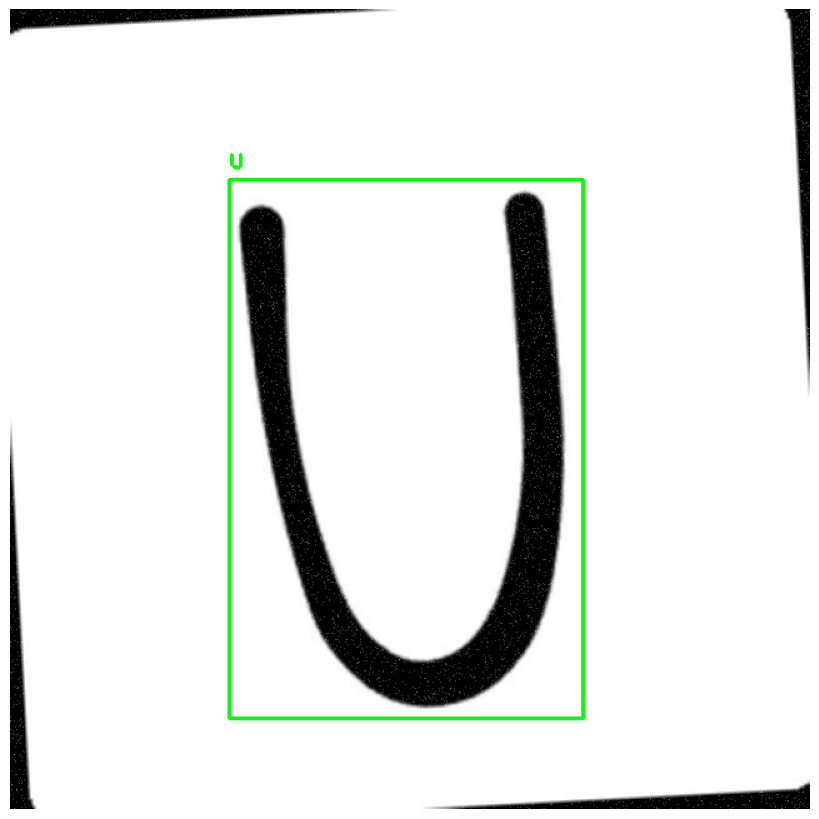

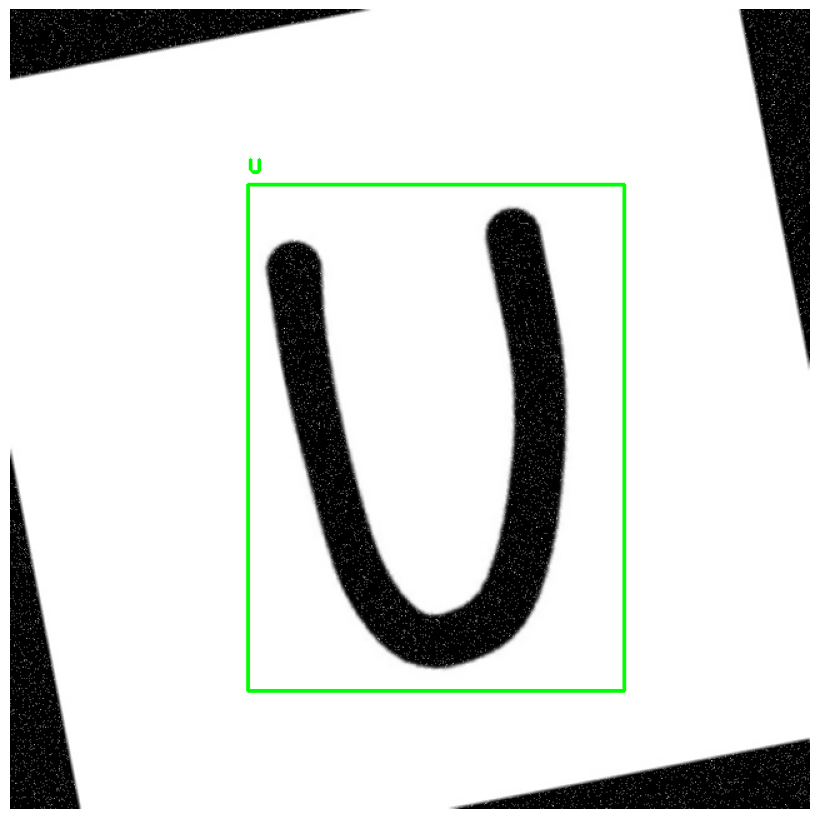

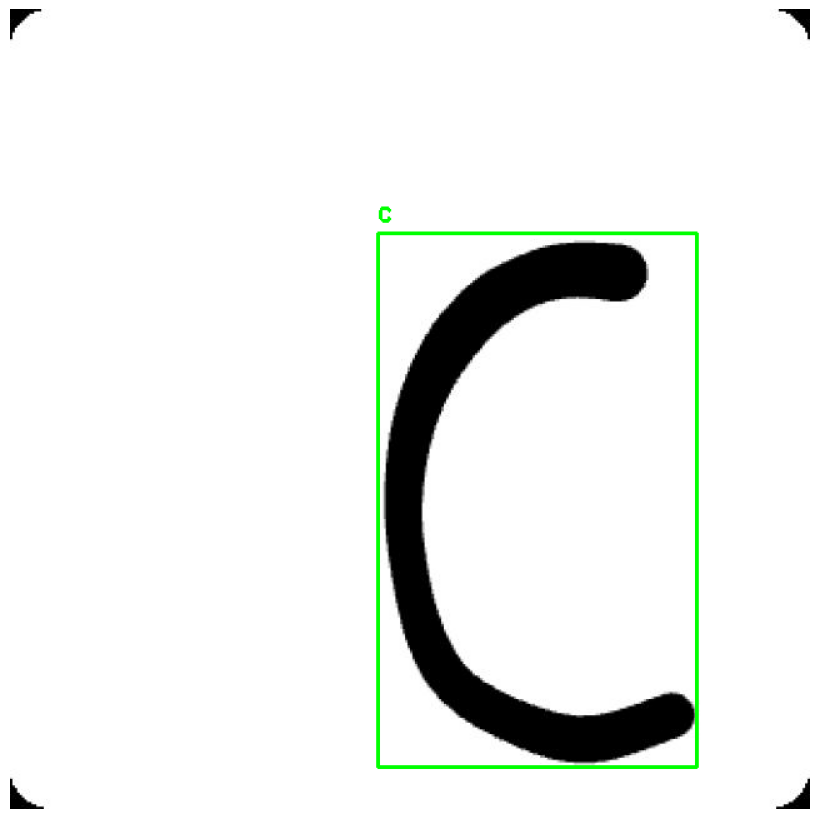

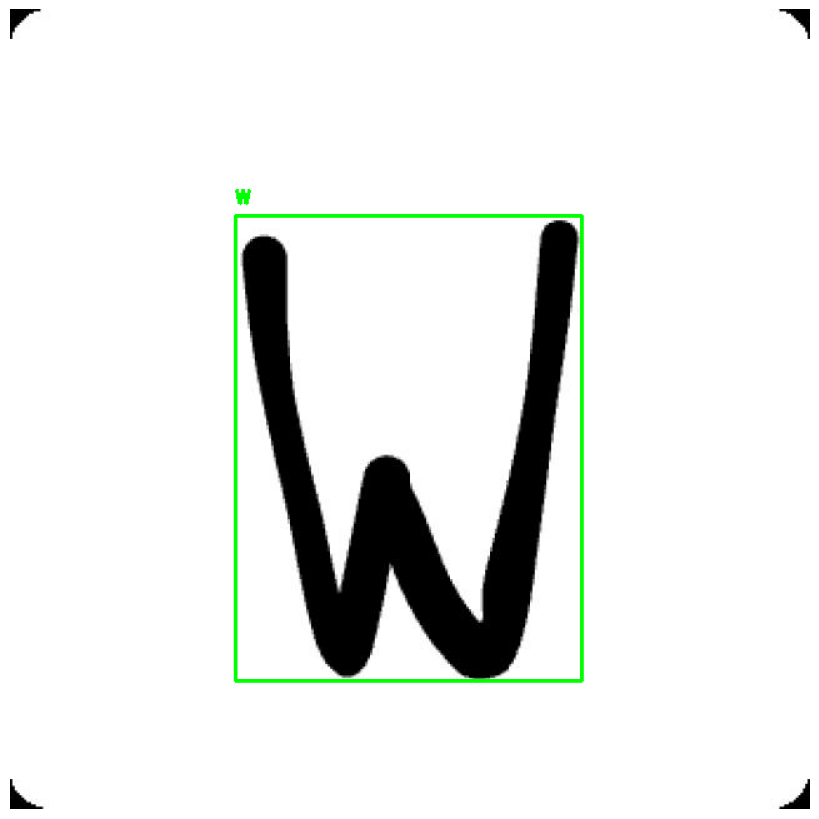

In [ ]:
def visualize_image_with_bboxes(img_path, label_path, class_names):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot read image: {img_path}")
        return
    h, w = img.shape[:2]

    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                class_id = int(float(parts[0]))
                x_center, y_center, bbox_w, bbox_h = map(float, parts[1:5])
                x1 = int((x_center - bbox_w / 2) * w)
                y1 = int((y_center - bbox_h / 2) * h)
                x2 = int((x_center + bbox_w / 2) * w)
                y2 = int((y_center + bbox_h / 2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = class_names[class_id] if class_id < len(class_names) else f"class_{class_id}"
                cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.margins(0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.gca().set_frame_on(False)
        plt.show()

    except Exception as e:
        print(f"Error processing {label_path}: {e}")

train_img_files = glob.glob(str(base_path / "train" / "images" / "*.*"))
if train_img_files:
    sample_imgs = random.sample(train_img_files, min(6, len(train_img_files)))
    for img_path in sample_imgs:
        label_path = str(Path(img_path).with_suffix(".txt")).replace("images", "labels")
        if os.path.exists(label_path):
            visualize_image_with_bboxes(img_path, label_path, class_names)

Image 1: image2-5-_png.rf.5d2b49ed5f23e4ac1d0b9a0a8402b52d_aug_2.jpg — Size: 640x640, Channels: 3


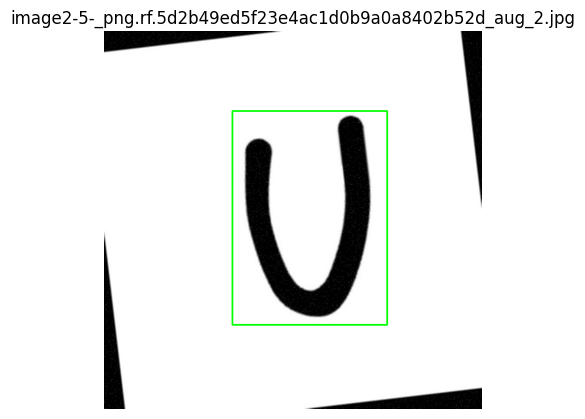

Image 2: image2-4-_png.rf.6f7b8510855a809b40011efd419a5038_aug_1.jpg — Size: 640x640, Channels: 3


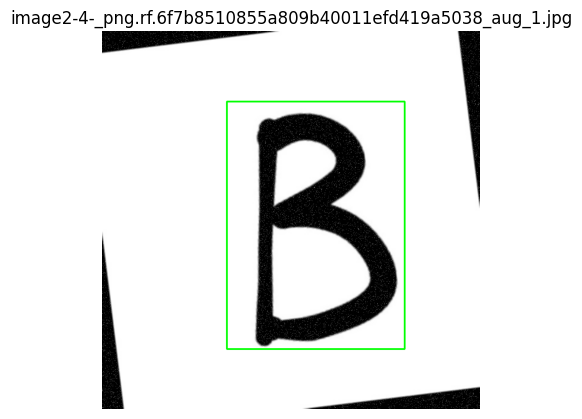

Image 3: image1-25-_png.rf.267a579f1afc83c060e09d3eb48cc94c_aug_4.jpg — Size: 640x640, Channels: 3


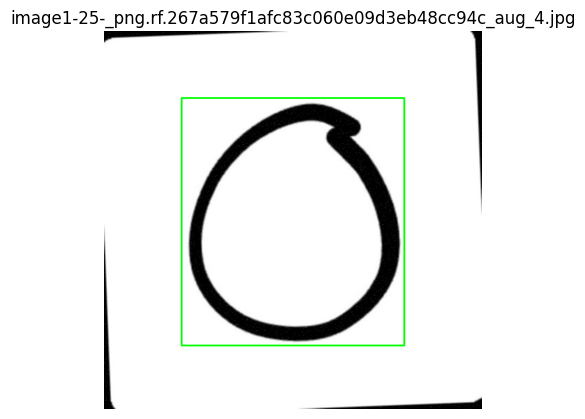

Image 4: image1-7-_png.rf.6e4984c7247237b084516e4ff2c0ad17_aug_4.jpg — Size: 640x640, Channels: 3


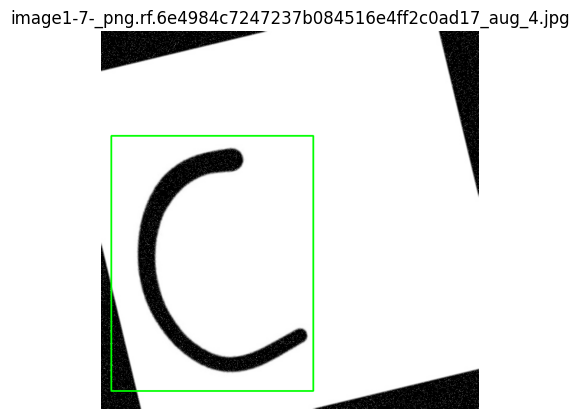

Image 5: image-11-_png.rf.92048976f51048be34570984ac16e364.jpg — Size: 640x640, Channels: 3


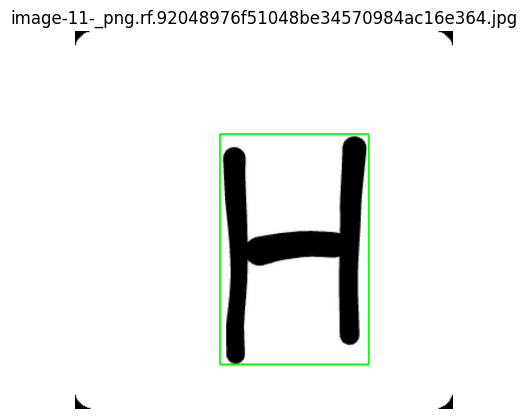

In [ ]:
# Display 5 random images with bounding boxes
sample_images = random.sample(glob.glob(str(train_img_dir / "*.*")), 5)

for i, img_path in enumerate(sample_images, 1):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue

    height, width, channels = img.shape
    print(f"Image {i}: {Path(img_path).name} — Size: {width}x{height}, Channels: {channels}")

    # Read corresponding label file
    label_path = str(Path(img_path).with_suffix(".txt")).replace("images", "labels")
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id, x_center, y_center, w, h = map(float, parts)
                # Convert YOLO format (relative) to pixel values
                x1 = int((x_center - w / 2) * width)
                y1 = int((y_center - h / 2) * height)
                x2 = int((x_center + w / 2) * width)
                y2 = int((y_center + h / 2) * height)
                # Draw rectangle (no border/frame)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Show image without white border
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(Path(img_path).name)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


In [ ]:
# --- 6. Class Imbalance Metrics ---
cls_df_train = get_class_distribution("train", class_names)
if not cls_df_train.empty:
    max_count = cls_df_train["count"].max()
    min_count = cls_df_train["count"].min()
    imbalance_ratio = max_count / min_count if min_count > 0 else float("inf")
    print("Class imbalance metrics (Train split):")
    print(f"Max class count: {max_count}")
    print(f"Min class count: {min_count}")
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}\n")


Class imbalance metrics (Train split):
Max class count: 228
Min class count: 192
Imbalance ratio (max/min): 1.19



## Custom Training

In [ ]:
!pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --force-reinstall

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.4/838.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 756.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=50 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 215MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return to

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    train_batch13960.jpg
confusion_matrix_normalized.png			    train_batch13961.jpg
confusion_matrix.png				    train_batch13962.jpg
events.out.tfevents.1745604005.0a8e493063b1.3861.0  train_batch1.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


/content


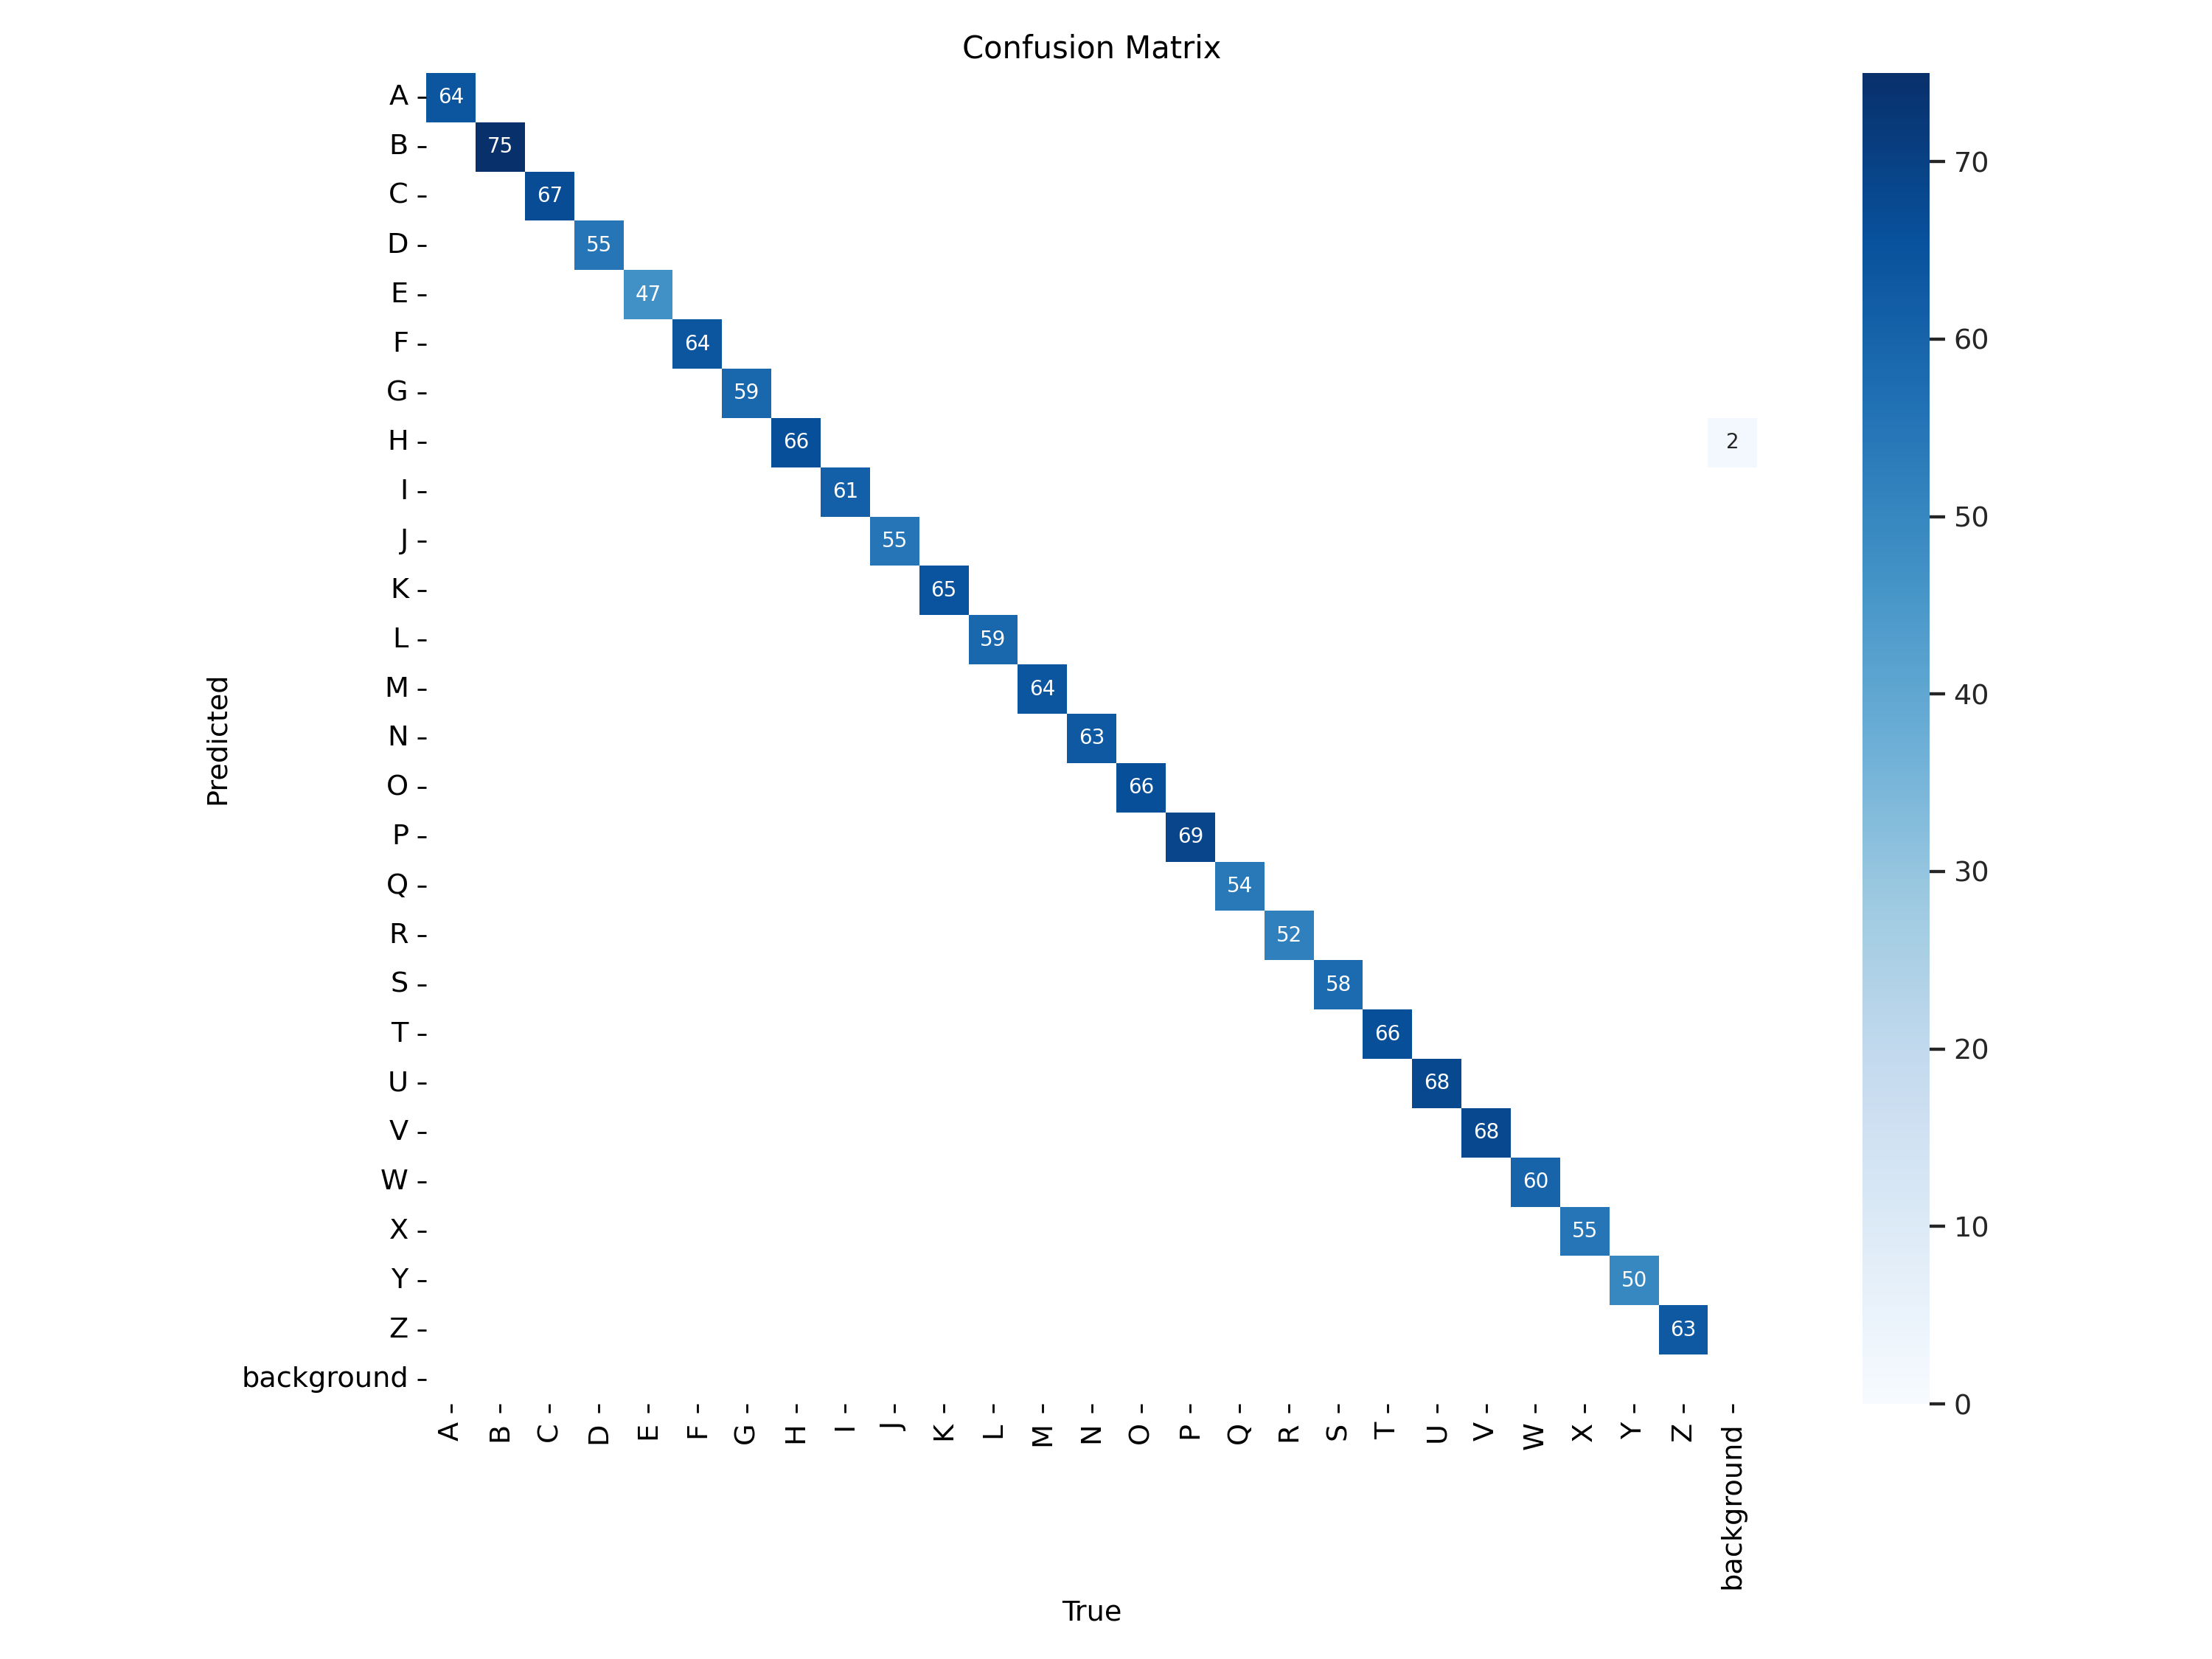

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


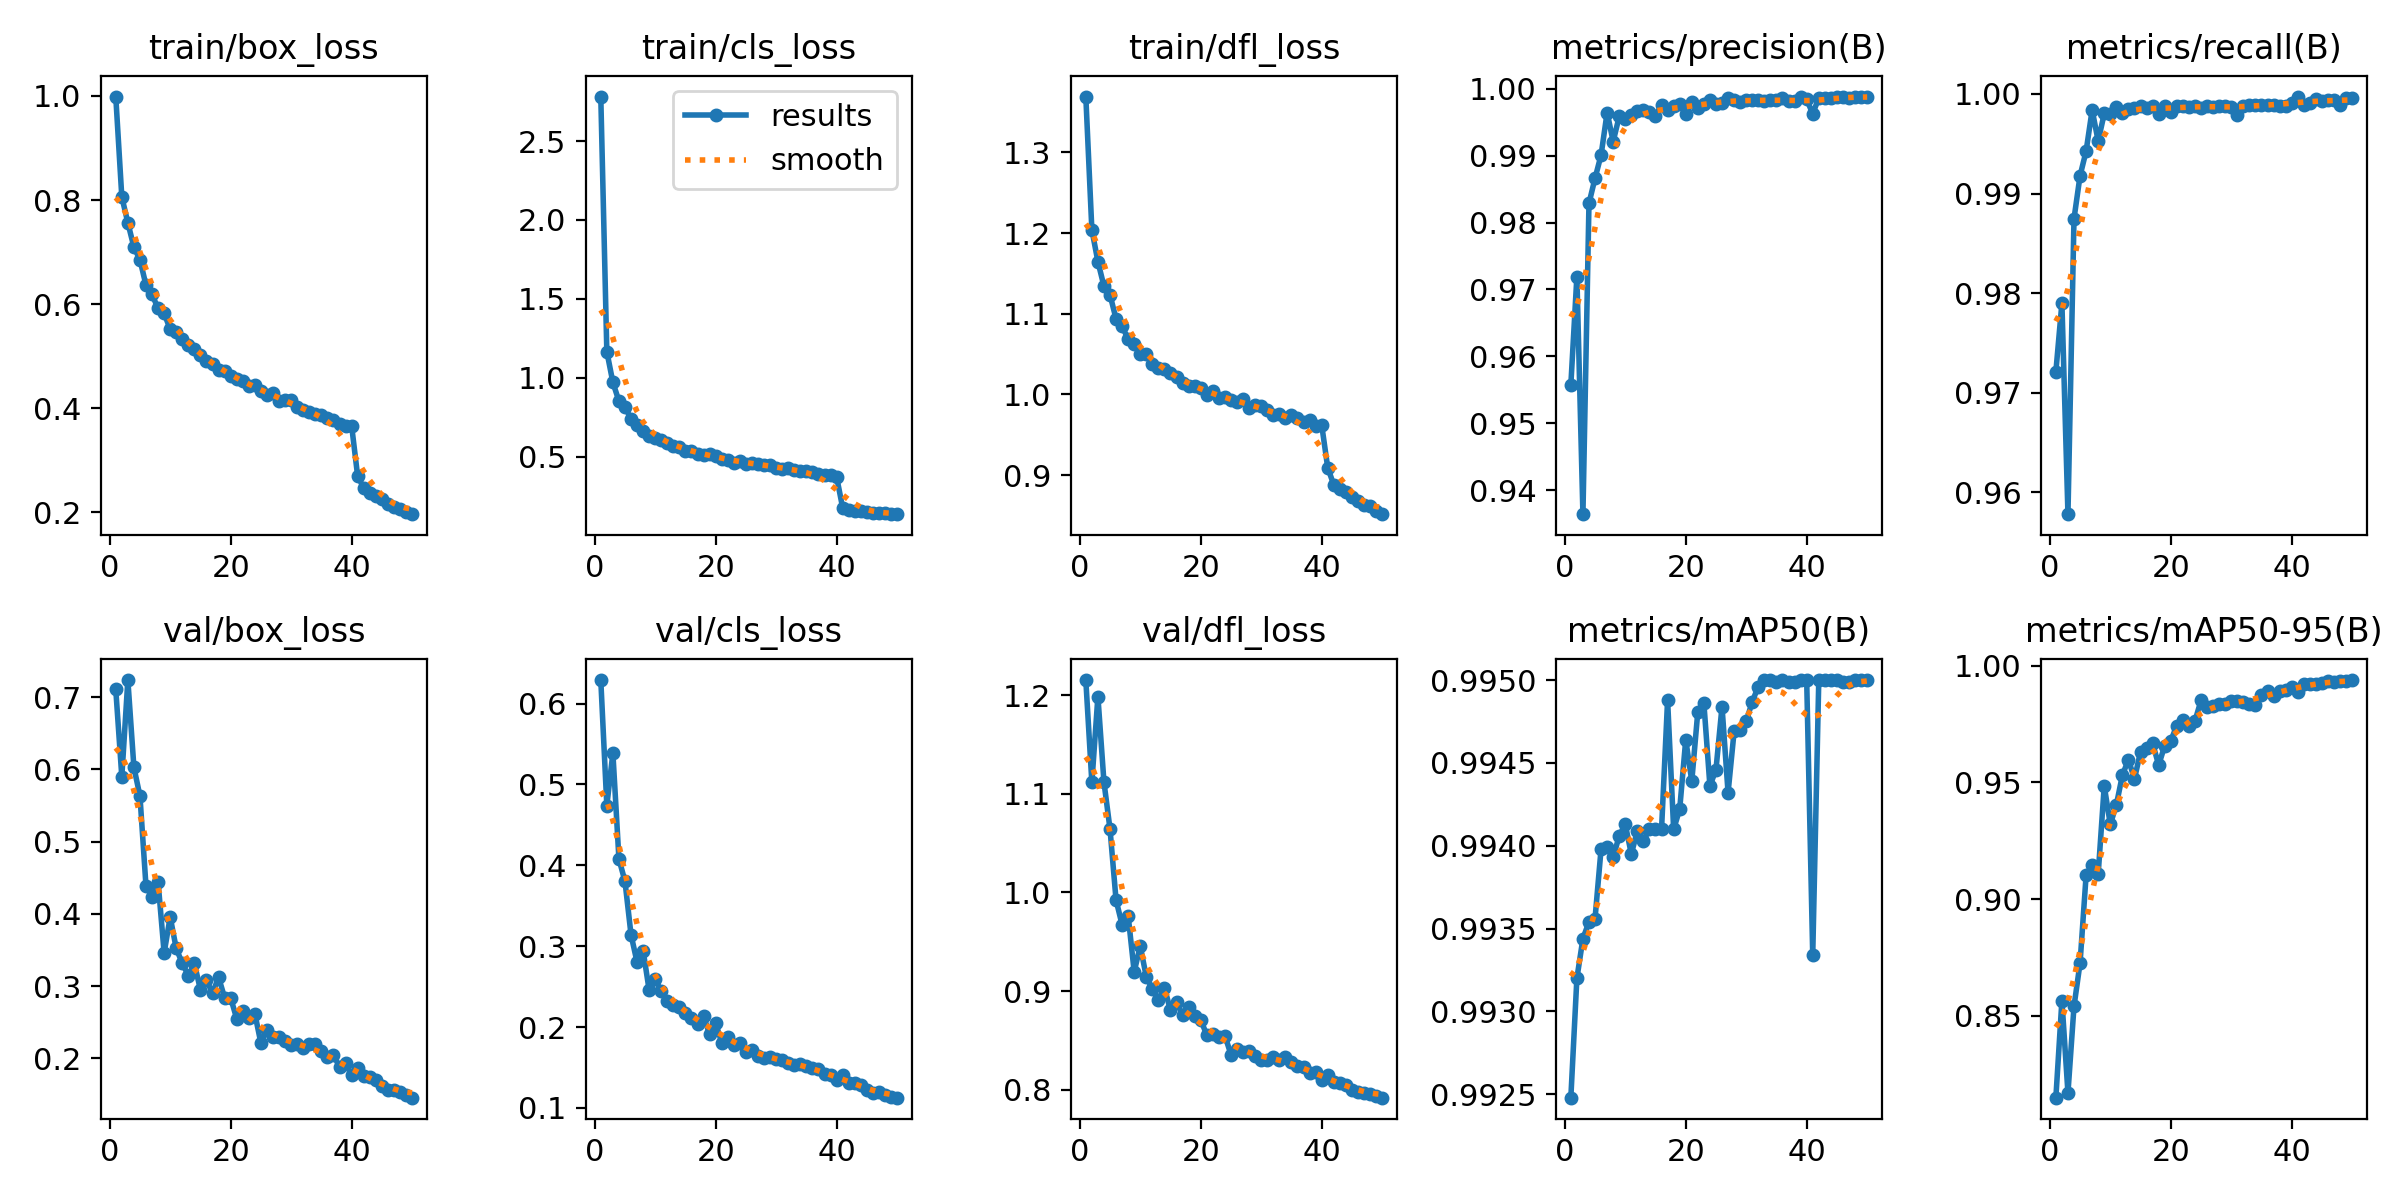

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


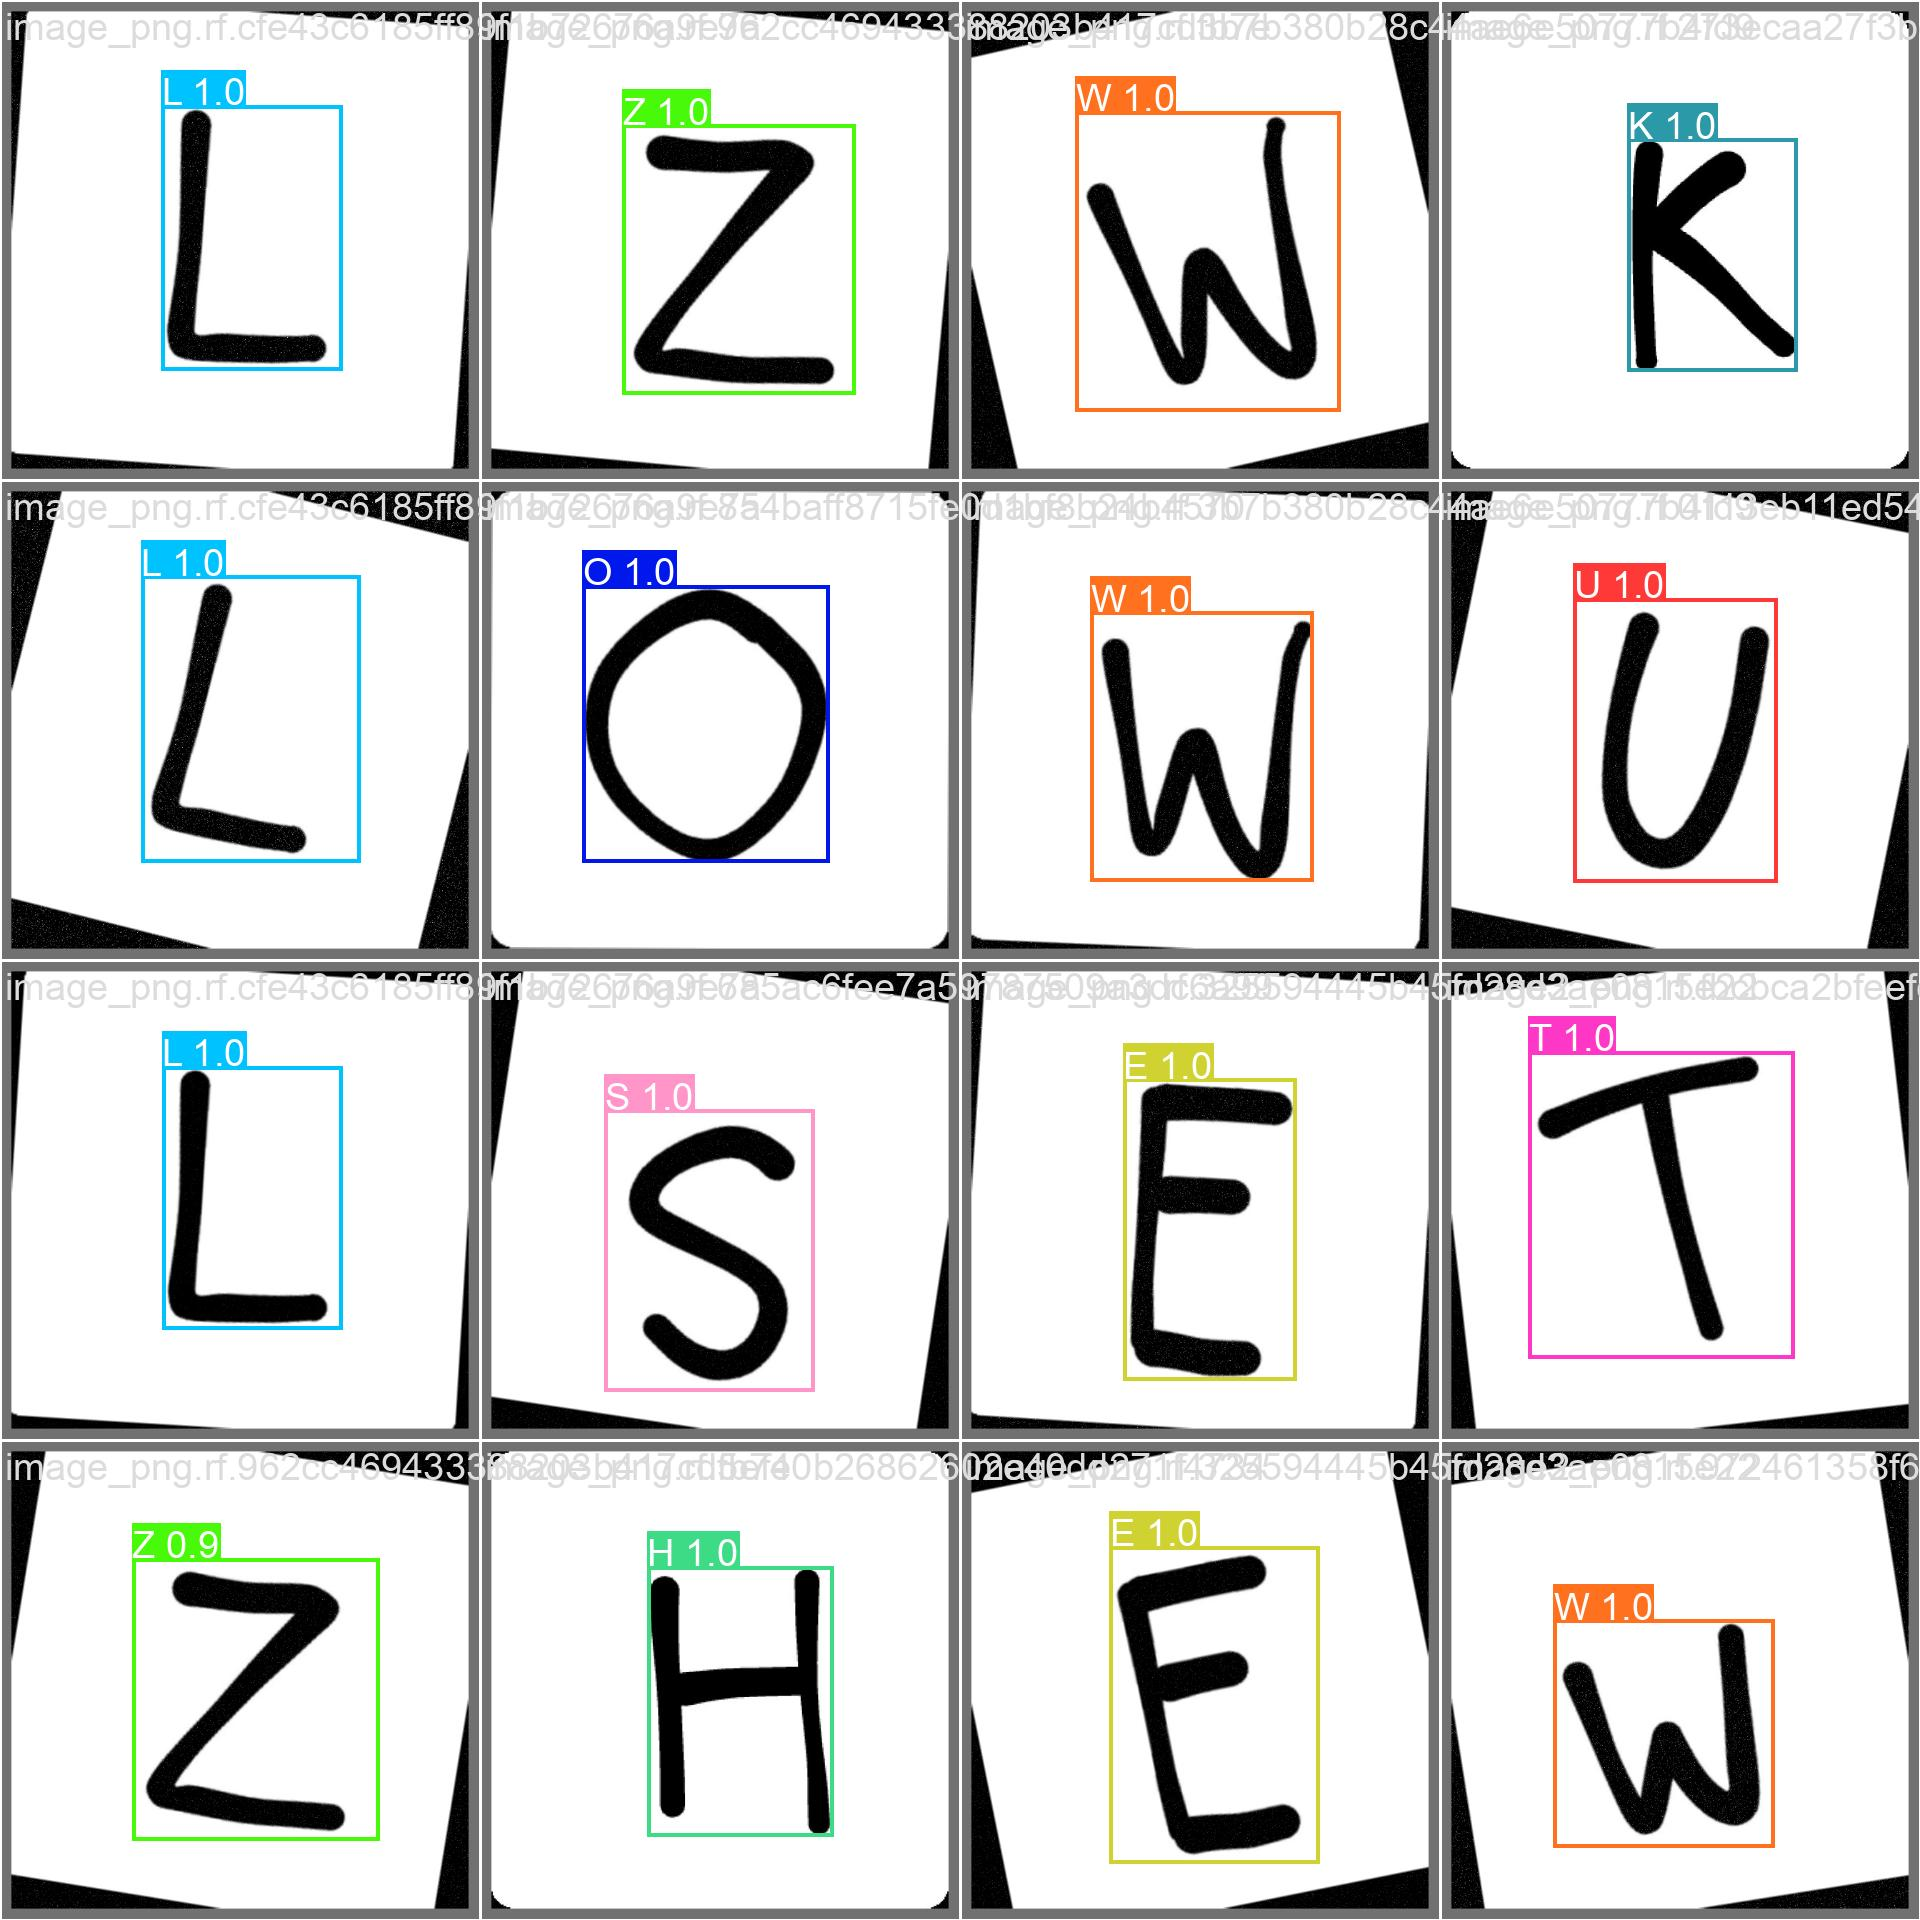

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

In [ ]:
!cp -r /content/runs /content/drive/MyDrive/handwritingalphabet

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Change this path to match your folder structure
train_folder_path = '/content/drive/MyDrive/handwritingalphabet/detect/train'


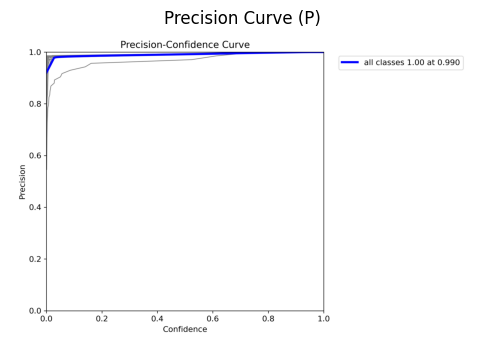

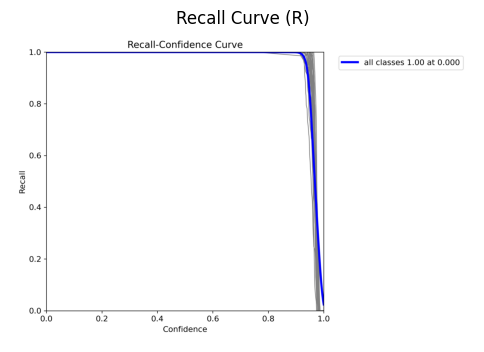

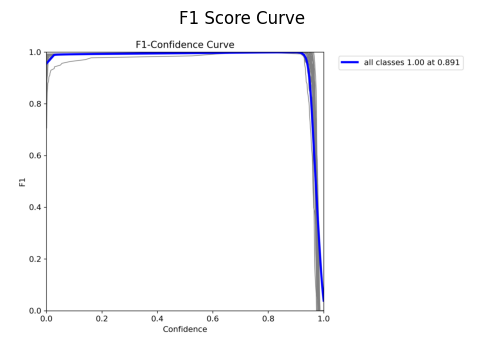

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths to the images
p_curve_path = f'{train_folder_path}/P_curve.png'
r_curve_path = f'{train_folder_path}/R_curve.png'
f1_curve_path = f'{train_folder_path}/F1_curve.png'

# Function to display images
def display_image(image_path, title):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display each chart
display_image(p_curve_path, 'Precision Curve (P)')
display_image(r_curve_path, 'Recall Curve (R)')
display_image(f1_curve_path, 'F1 Score Curve')
